In [1]:
import os
import pandas as pd
from rouge import Rouge
import nltk
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv("C:\\Users\\leshanbog\\Documents\\GitHub\\lasertagger\\model\\ria_test_pred.tsv", sep='\t', names=['text', 'pred', 'true'])
data = data.dropna()

In [3]:
data.shape

(4266, 3)

In [4]:
data.head()

,text,pred,true
0,"москва, 25 апр - риа новости. полный состав жю...",полный состав жюри каннского объявлен,модельера жан-поля готье позвали в жюри каннск...
1,18 апреля в вологде стартовал двухмесячник по ...,в вологде стартовал двухмесячник по благоустро...,работники вологодского кремля очистили музей-з...
2,"кабул, 21 апр - риа новости, андрей грешнов. к...",крупнейший афганский банк подвергнется санации...,часть активов рухнувшего kabul bank будет расп...
3,"москва, 31 авг - риа новости. возможность сыгр...",возможность сыграть повлияла на решение кежман...,форвард кежман перешел в фк батэ из-за участия...
4,"москва, 24 ноября - риа новости. совет федерац...",сф одобрил закон о передаче религиозным органи...,совфед одобрил нашумевший закон о передаче иму...


In [5]:
refs = list(data['true'])
hyps = list(data['pred'])

In [46]:
def calc_legacy_rouge(refs, hyps, directory="eval"):
    from pyrouge import Rouge155
    r = Rouge155()
    system_dir = os.path.join(directory, 'hyp')
    model_dir = os.path.join(directory, 'ref')
    if not os.path.isdir(system_dir):
        os.makedirs(system_dir)
    if not os.path.isdir(model_dir):
        os.makedirs(model_dir)
    r.system_dir = system_dir
    r.model_dir = model_dir
    r.system_filename_pattern = '(\d+)_decoded.txt'
    r.model_filename_pattern = '#ID#_reference.txt'
    for i, (ref, hyp) in enumerate(zip(refs, hyps)):
        hyp_file_path = os.path.join(r.system_dir, "%06d_decoded.txt" % i)
        with open(hyp_file_path, "w") as w:
            hyp_sentences = hyp.split(" s_s ")
            w.write("\n".join(hyp_sentences))
        ref_file_path = os.path.join(r.model_dir, "%06d_reference.txt" % i)
        with open(ref_file_path, "w") as w:
            ref_sentences = ref.split(" s_s ")
            w.write("\n".join(ref_sentences))
    output = r.convert_and_evaluate()
    result = r.output_to_dict(output)
    log_str = ""
    for x in ["1","2","l"]:
        log_str += "\nROUGE-%s:\n" % x
        for y in ["f_score", "recall", "precision"]:
            key = "rouge_%s_%s" % (x,y)
            key_cb = key + "_cb"
            key_ce = key + "_ce"
            val = result[key]
            val_cb = result[key_cb]
            val_ce = result[key_ce]
            log_str += "%s: %.4f with confidence interval (%.4f, %.4f)\n" % (key, val, val_cb, val_ce)
    return log_str


def calc_metrics(refs, hyps):
    print("Count:", len(hyps))
    print('Text:', data['text'].iloc[-1])
    print("Ref:", refs[-1])
    print("Hyp:", hyps[-1])
    

    from nltk.translate.bleu_score import corpus_bleu
    print("BLEU: ", corpus_bleu([[r] if r is not list else r for r in refs], hyps))
    rouge = Rouge()
    scores = rouge.get_scores(hyps, refs, avg=True)
    print("ROUGE: ", scores)

In [47]:
calc_metrics(refs, hyps)

Count: 4266
Text: казань, 9 янв - р-спорт, вадим кузнецов. нападающий хоккейного клуба ска илья ковальчук заявил, что он не исключает вариант, при котором он останется в кхл до окончания сезона, несмотря на завершившийся в нхл локаут. во вторник ска в казани проиграл "ак барсу" со счетом 1:3. ранее стало известно, что нхл и профсоюз игроков (nhlpa) достигли предварительного соглашения по новому коллективному договору. "останусь ли я
Ref: ковальчук не исключил, что не уедет в нхл по окончании локаута
Hyp: хоккеист ска ковальчук не исключает вариант, при котором останется в кхл
BLEU:  0.49222670589092754
ROUGE:  {'rouge-1': {'f': 0.36426029765140144, 'p': 0.3949163534196342, 'r': 0.35010224317537647}, 'rouge-2': {'f': 0.19398912306529087, 'p': 0.2118364109088529, 'r': 0.1867723352076363}, 'rouge-l': {'f': 0.3352209466184624, 'p': 0.3757420710421161, 'r': 0.3330723867995289}}


In [16]:
n = random.randint(0, len(refs) - 1)

In [20]:
data['text'][n].replace(' ##', '')

'воронеж, 22 ноя - риа новости. мокрый снег и скользкая трасса стали причиной столкновения шести автомобилей на эстакаде над парком "динамо" в воронеже, всего с начала дня из-за непогоды в городе произошло более 80 дтп, сообщил риа новости представитель гибдд воронежской области. "авария произошла около 15.30 мск. какие именно автомобили столкнулись, у нас пока информации нет", - сказал собеседник агентства. по свидетельствам очевидцев, из'

In [21]:
data['pred'][n].replace(' ##', '')

'и скользкая трасса стали причиной столкновения шести автомобилей над парком "динамо"'

In [22]:
data['true'][n].replace(' ##', '')

'шесть машин столкнулись в воронеже на скользкой трассе'

In [40]:
def get_distribution_tsv():
    from_first_sentence_tokens_percert = []

    for i in range(len(data['text'])):
        sent_tokens = data['text'].iloc[i].split()
        try:
            header_end_pos = sent_tokens.index('.')
        except:
            continue

        try:
            first_sent = sent_tokens[header_end_pos + 1 : header_end_pos + sent_tokens[header_end_pos + 1:].index('.')]
        except:
            first_sent = sent_tokens[header_end_pos + 1 : -1]

        pred_tokens = data['pred'].iloc[i].split()
        token_from_first_sent_cnt = 0
        for el in pred_tokens:
            if el in first_sent:
                token_from_first_sent_cnt += 1

        from_first_sentence_tokens_percert.append(token_from_first_sent_cnt / len(pred_tokens))
    
    return from_first_sentence_tokens_percert

In [41]:
def get_distribution_ria():
    from_first_sentence_tokens_percert = []

    for i in range(len(data['text'])):
        sent_tokens = data['text'].iloc[i]
        try:
            sent_tokens = sent_tokens.split('.')[1]
        except:
            continue
        first_sent = sent_tokens.split()

        pred_tokens = data['pred'].iloc[i].split()
        token_from_first_sent_cnt = 0
        for el in pred_tokens:
            if el in first_sent:
                token_from_first_sent_cnt += 1

        from_first_sentence_tokens_percert.append(token_from_first_sent_cnt / len(pred_tokens))
    
    return from_first_sentence_tokens_percert

In [42]:
from_first_sentence_tokens_percert = get_distribution_ria()

In [43]:
sum(from_first_sentence_tokens_percert) / len(from_first_sentence_tokens_percert)

0.8053666695772178

In [44]:
sorted(from_first_sentence_tokens_percert)[len(from_first_sentence_tokens_percert)//2]

0.9

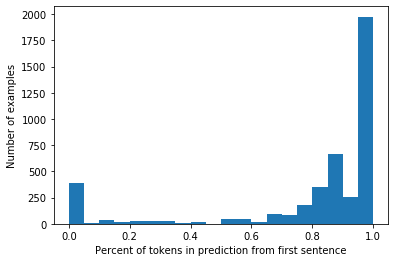

In [45]:
plt.xlabel('Percent of tokens in prediction from first sentence')
plt.ylabel('Number of examples')
plt.hist(from_first_sentence_tokens_percert, 20)
plt.show()